> **Quantinuum Nexus Note:** To properly run the 'problem-setting' notebook within the Quantinuum Nexus Lab Jupyter environment install the following packages using `pip`:

```bash
pip install qiskit-finance pylatexenc perfplot

In [1]:
#pip install qiskit-finance pylatexenc perfplot

In [2]:
# imports
import numpy as np

In [3]:
# set problem parameters
N_z = 32
n_z = int(np.ceil(np.log2(N_z)))
z_max = 3
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25, 0.2, 0.1]
rhos = [0.1, 0.05, 0.15, 0.05]
lgd = [1, 2, 1, 3]
K = len(p_zeros)

## Qiskit implementation

Qiskit already has an implementation for this model. It is within [`qiskit_finance`](https://qiskit-community.github.io/qiskit-finance/). The implementation is imported below as `GCI`.

Let's take a closer look at that implementation.

In [4]:
import qiskit as q

# took from qiskit_finance.circuit.library
"""The Gaussian Conditional Independence Model for Credit Risk."""

from typing import List, Union
import numpy as np
from scipy.stats.distributions import norm

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import LinearPauliRotations
from qiskit_finance.circuit.library.probability_distributions.normal import (
    NormalDistribution,
)


class GCI(q.QuantumCircuit):
    """The Gaussian Conditional Independence Model for Credit Risk.
    Reference: https://arxiv.org/abs/1412.1183
    Dependency between individual risk variables and latent variable is approximated linearly.
    """

    def __init__(
        self,
        n_normal: int,
        normal_max_value: float,
        p_zeros: Union[List[float], np.ndarray],
        rhos: Union[List[float], np.ndarray],
    ) -> None:
        """
        Args:
            n_normal: Number of qubits to represent the latent normal random variable Z
            normal_max_value: Min/max value to truncate the latent normal random variable Z
            p_zeros: Standard default probabilities for each asset
            rhos: Sensitivities of default probability of assets with respect to latent variable Z
        """
        self.n_normal = n_normal
        self.normal_max_value = normal_max_value
        self.p_zeros = p_zeros
        self.rhos = rhos
        num_qubits = n_normal + len(p_zeros)

        # get normal (inverse) CDF and pdf (these names are from the paper, therefore ignore
        # pylint)
        def F(x):  # pylint: disable=invalid-name
            return norm.cdf(x)

        def F_inv(x):  # pylint: disable=invalid-name
            return norm.ppf(x)

        def f(x):  # pylint: disable=invalid-name
            return norm.pdf(x)

        # create linear rotations for conditional defaults
        slopes = []
        offsets = []
        for rho, p_zero in zip(rhos, p_zeros):
            psi = F_inv(p_zero) / np.sqrt(1 - rho)

            # compute slope / offset
            slope = -np.sqrt(rho) / np.sqrt(1 - rho)
            slope *= f(psi) / np.sqrt(1 - F(psi)) / np.sqrt(F(psi))
            offset = 2 * np.arcsin(np.sqrt(F(psi)))

            # adjust for integer to normal range mapping
            offset += slope * (-normal_max_value)
            slope *= 2 * normal_max_value / (2**n_normal - 1)

            offsets += [offset]
            slopes += [slope]

        # create normal distribution
        normal_distribution = NormalDistribution(
            n_normal,
            0,
            1,
            bounds=(-normal_max_value, normal_max_value),
        )

        # build circuit
        inner = QuantumCircuit(num_qubits, name="P(X)")
        inner.append(normal_distribution.to_gate(), list(range(n_normal)))
        for k, (slope, offset) in enumerate(zip(slopes, offsets)):
            lry = LinearPauliRotations(n_normal, slope, offset)
            qubits = list(range(n_normal)) + [n_normal + k]
            inner.append(lry.to_gate(), qubits)

        super().__init__(num_qubits, name="P(X)")
        self.append(inner.to_gate(), inner.qubits)


# Create unitary
u = GCI(n_z, z_max, p_zeros, rhos)

# Draw the unitary (decomposed)
u.decompose().draw()

┌───────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤0      ├┤0        ├┤0        ├┤0        ├┤0        ├
     │       ││         ││         ││         ││         │
q_1: ┤1      ├┤1        ├┤1        ├┤1        ├┤1        ├
     │       ││         ││         ││         ││         │
q_2: ┤2 P(X) ├┤2        ├┤2        ├┤2        ├┤2        ├
     │       ││  LinRot ││         ││         ││         │
q_3: ┤3      ├┤3        ├┤3 LinRot ├┤3        ├┤3        ├
     │       ││         ││         ││  LinRot ││         │
q_4: ┤4      ├┤4        ├┤4        ├┤4        ├┤4 LinRot ├
     └───────┘│         ││         ││         ││         │
q_5: ─────────┤5        ├┤         ├┤         ├┤         ├
              └─────────┘│         ││         ││         │
q_6: ────────────────────┤5        ├┤         ├┤         ├
                         └─────────┘│         ││         │
q_7: ───────────────────────────────┤5        ├┤         ├
                                    └─────────┘│         │
q_8: ──────────────────────────────────────────┤5        ├
                                               └─────────┘

## Creating P(X)

The linear rotations are not that interesting for now. Let us inspect the `P(X)` part of the circuit.

In [5]:
# Create normal distribution
normal_distribution = NormalDistribution(
    n_z,
    0,
    1,
    bounds=(-z_max, z_max),
)

# Draw it
normal_distribution.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2 P(X) ├
     │       │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     └───────┘

But what is inside? To find that out, we transpile the gate.

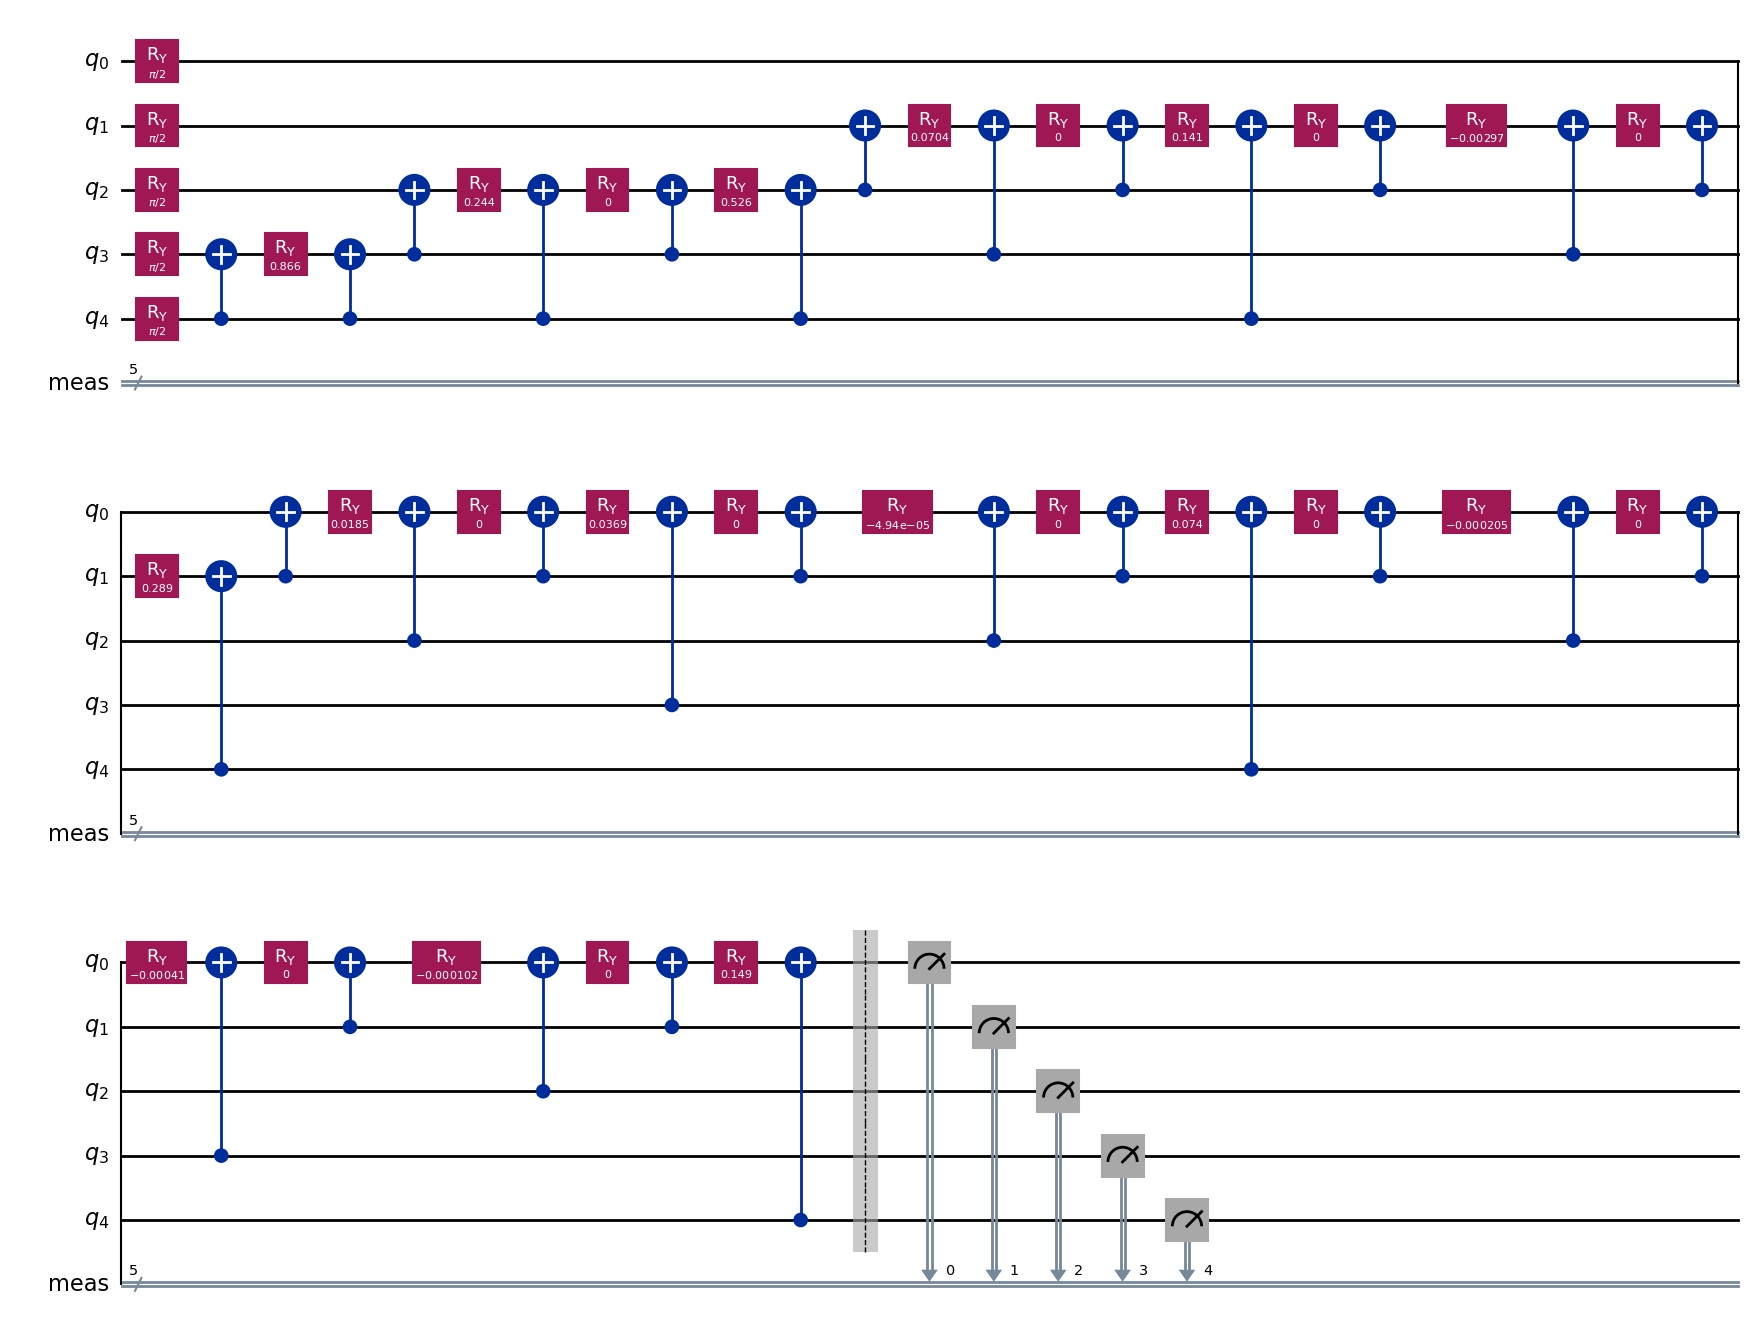

In [6]:
# Define which basis gates to use
basis_gates = ["h", "ry", "cx", "p", "x", "s", "sdg", "y", "t"]

# Transpile the circuit
normal_distribution.measure_all("meas")
normal_distribution_transpiled = q.transpile(
    normal_distribution, basis_gates=basis_gates
)

# Draw it
normal_distribution_transpiled.draw("mpl")

As you can see, the number of controlled gates on the 2nd qubit (q3) is not that high (2), but then the number of controlled gates on the next qubit (q2) is already 4. q1 has 8 controlled gates and q0 has 16 controlled gates. I.e., the circuit depth scales exponential.

That is bad!

Quantum computers of today have many qubits ($O(100)$), but the qubits are not very good. Noise takes over quickly.

Let's see what that means.

## Running on H-Series Emulators

First convert Qiskit circuit to `pytket` circuit

In [7]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = qiskit_to_tk(normal_distribution)
render_circuit_jupyter(tket_circuit)

It is straight forward in `pytket` to decompose the above box into elementary gates. The `DecomposeBoxes()` transform allows us to do this:

In [8]:
from pytket.transform import Transform
Transform.DecomposeBoxes().apply(tket_circuit)

render_circuit_jupyter(tket_circuit)

Set up Quantinuum Nexus Project and Backend

In [10]:
from pytket.extensions.nexus import Nexus
from datetime import datetime

nexus = Nexus()
my_project = nexus.new_project(name=f"test_1")


New project created: test_1


In [11]:
from pytket.extensions.nexus import QuantinuumConfig


configuration = QuantinuumConfig(device_name="H1-1LE")

In [12]:
from pytket.extensions.nexus import NexusBackend

# Then we'll create a NexusBackend using our config and the project we created
backend_LE = NexusBackend(configuration, project=my_project)

compiled_circ_Hseries_LE = backend_LE.get_compiled_circuit(tket_circuit, optimisation_level = 2)


Started using project with name: test_1


In [13]:
handle_LE =  backend_LE.process_circuit(compiled_circ_Hseries_LE, n_shots=100)
print(backend_LE)

In [14]:
status = backend_LE.circuit_status(handle_LE)
print(status)

CircuitStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Circuit has been submitted to Nexus for Processing.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 4, 13, 15, 17, 17, 448846, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)


With `pytket` we can also run on the `AerBackend` for comparing to simulation

In [15]:
from pytket.extensions.qiskit import AerBackend
aer_b = AerBackend()

n_shots = 300

handle = aer_b.process_circuit(tket_circuit, n_shots=n_shots, seed=1)
counts = aer_b.get_result(handle).get_counts()




Now let's plot, using the Qiskit plotting tool

In [ ]:
from qiskit.visualization import plot_distribution


result_LE = backend_LE.get_result(handle_LE)
counts_Hserie_LE = result_LE.get_counts()


# Note: state basis numbers in Qiskit and pytket are switched, hence need to be corrected to use the plot_distribution function
counts_Hserie_LE = {key[::-1]: value for key, value in counts_Hserie_LE.items()}
counts_exact = {key[::-1]: value for key, value in counts.items()}

# Now plot the results
plot_distribution(
    [counts_Hserie_LE, counts_exact], legend=["counts_Hserie_LE", "exact"], bar_labels=False
)